<a href="https://colab.research.google.com/github/shaoyinguo-portfolio/CorpGenie-exp/blob/main/Video2Slides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Sample YouTube video](https://www.youtube.com/watch?v=GfiaHEhFHaM)

[Download site](https://www.mediamister.com/free-youtube-video-downloader)

In [1]:
import cv2
from google.colab import drive
from matplotlib import pyplot as plt
import numpy as np
# from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from pathlib import Path
from time import time

try:
    import gdown
except:
    !pip install gdown
    import gdown

In [2]:
try:
    drive.mount('/content/drive')
    data_path = Path('/content/drive/MyDrive/Colab Notebooks/data')
    print('Mounted Google Drive')
except:
    data_path = Path('./data')
    print('Mounted local drive')

if not data_path.exists():
    data_path.mkdir()

VIDEO_PATH = f'{data_path}/video.data'
AUDIO_PATH = f'{data_path}/audio.data'
TRANSCRIPT_PATH = f'{data_path}/transcripts.txt'
KEYFRAME_PATH = f'{data_path}/key_frames'

gdown.download(url='https://drive.google.com/uc?id=1XfDxDUFQ2bSOCO0DzQtyH2Yzg9Ff0S-F', output=VIDEO_PATH, quiet=False)
gdown.download(url='https://drive.google.com/uc?id=1EhqRX_hnPeyc13Zimh11gdUnUIyCEhN6', output=AUDIO_PATH, quiet=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1XfDxDUFQ2bSOCO0DzQtyH2Yzg9Ff0S-F
From (redirected): https://drive.google.com/uc?id=1XfDxDUFQ2bSOCO0DzQtyH2Yzg9Ff0S-F&confirm=t&uuid=4ca8a28c-7c57-42f5-81b9-0f403ac70252
To: /content/drive/MyDrive/Colab Notebooks/data/video.data
100%|██████████| 117M/117M [00:01<00:00, 69.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EhqRX_hnPeyc13Zimh11gdUnUIyCEhN6
To: /content/drive/MyDrive/Colab Notebooks/data/audio.data
100%|██████████| 22.2M/22.2M [00:00<00:00, 49.5MB/s]


'/content/drive/MyDrive/Colab Notebooks/data/audio.data'

In [7]:
class VideoToSlides:
  def __init__(self, config=None, debug=False):

    if config is None:
      config = {}

    self.pixel_threshold = config.get('pixel_threshold', 25)
    self.frame_crop = config.get('frame_crop', None)
    self.kernel_size = config.get('kernel_size', 0.05) # default 5% of smaller frame dimension
    self.density_threshold = config.get('density_threshold', 0) # default no sesami filter
    self.diff_cutoff = config.get('diff_cutoff', 0.1)
    self.save_path = config.get('save_path', None) # None outputs key frames in a list

    self.debug = debug


  def _crop_frame(self, frame):
    """Crop frame to focus zone"""

    if len(frame.shape) != 2:
      raise ValueError('Frame must be grayscale')

    if self.frame_crop is None:
      return frame

    crop_range = {
      'x_start': int(frame.shape[1] * (1 - self.frame_crop) / 2),
      'x_end': int(frame.shape[1] * (1 + self.frame_crop) / 2),
      'y_start': int(frame.shape[0] * (1 - self.frame_crop) / 2),
      'y_end': int(frame.shape[0] * (1 + self.frame_crop) / 2)
    }

    return frame[
        crop_range['y_start']:crop_range['y_end'],
        crop_range['x_start']:crop_range['x_end']
    ]


  def _remove_sesami(self, frame):
    """Filter sparse pixels"""

    if len(frame.shape) != 2:
      raise ValueError('Frame must be grayscale')

    kernel_size = self.kernel_size
    threshold = self.density_threshold

    if threshold == 0:
      return frame

    if kernel_size < 1: # relative to smaller frame dimension
      kernel_size = int(min(frame.shape) * kernel_size)
    if kernel_size % 2 == 0:
      kernel_size += 1

    if kernel_size < 3:
      print('Absolute kernel size must be at least 3')
      return frame

    # kernel = np.ones((kernel_size, kernel_size))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    kernel = kernel/kernel.ravel().sum()

    # moving average for local density distribution
    mask = cv2.filter2D(frame, -1, kernel)

    # find regions where local (center) density is higher than criteria
    _, mask = cv2.threshold(mask, int(255 * threshold), 255, cv2.THRESH_BINARY)
    mask = cv2.dilate(mask, (kernel!=0).astype('uint8'), iterations=1)

    return cv2.bitwise_and(mask, frame), mask


  def _get_diff(self, previous_frame, current_frame, sesami_filter_config=None):
    """Compute frame change metrics"""
    frame_diff = cv2.absdiff(previous_frame, current_frame)
    _, diff_mask = cv2.threshold(frame_diff, self.pixel_threshold, 255, cv2.THRESH_BINARY)
    if type(sesami_filter_config) == tuple:
      _, diff_mask = self._remove_sesami(diff_mask, *sesami_filter_config)
    total_change = float(np.sum(frame_diff))
    pixel_change = cv2.countNonZero(diff_mask) / (current_frame.shape[0] * current_frame.shape[1])
    return total_change, pixel_change

  def get_video_info(self, video_path):
    """Get video info"""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Process failed to open video: {video_path}")
      return
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return total_frames, fps, width, height

  def extract_chunk(self, args):
    """Extract key frames from video chunk"""
    t = time()
    video_path, frame_range, verbose = args
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Process failed to open video: {video_path}")
      return []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    if type(frame_range) == int:
      frame_start, frame_end, frame_interval = 0, frame_range, 1
    elif type(frame_range) == tuple:
      if len(frame_range) == 2:
        frame_start, frame_end = frame_range
        frame_interval = 1
      elif len(frame_range) == 3:
        frame_start, frame_end, frame_interval = frame_range
    else: # invalid frame_range will default to full video
      frame_start, frame_end, frame_interval = 0, total_frames, 1

    frame_end = min(frame_end, total_frames)

    if frame_start != 0:
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame_start)

    previous_frame, current_frame = None, None
    diff = []
    key_frames = []
    plot_count = 0

    total_count = len(range(frame_start, frame_end, frame_interval))
    for cnt, i in enumerate(range(frame_start, frame_end, frame_interval)):
      if verbose and (cnt==0 or cnt % int(total_count*0.1) == 0):
        dt = int(time() - t)
        print(f'[{dt//60}:{dt%60}] Processing frame {cnt+1} of {total_count} @ {i+1}, captured {len(key_frames)} key frames.')
      previous_frame = current_frame
      if frame_interval > 1:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if not ret:
        break
      current_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      current_frame = self._crop_frame(current_frame)
      if previous_frame is None:
        continue

      # compute diff:
      frame_diff = cv2.absdiff(previous_frame, current_frame)
      total_diff = float(np.sum(frame_diff)) / 255 / (current_frame.shape[0] * current_frame.shape[1])

      _, diff_mask = cv2.threshold(frame_diff, self.pixel_threshold, 255, cv2.THRESH_BINARY)
      _, diff_mask = self._remove_sesami(diff_mask)
      masked_diff = cv2.countNonZero(diff_mask) / (current_frame.shape[0] * current_frame.shape[1])

      diff.append((i, total_diff, masked_diff))

      if (i == frame_start or masked_diff > self.diff_cutoff) and np.sum(current_frame)>0:
        if self.save_path is not None:
          path = Path(self.save_path)
          if not path.exists():
            path.mkdir()
          cv2.imwrite(f'{path}/{(i/fps):.2f}.jpg', frame)
          key_frames.append(i)
        else:
          key_frames.append((i, current_frame))

      if self.debug and total_diff > 0 and plot_count < 20: # max 20 plots
        fig = plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(current_frame, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(frame_diff, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(diff_mask, cmap='gray')
        plt.axis('off')
        fig.suptitle(f'Timestamp: {(int(i / fps)//60):d}:{(int(i / fps)%60):d} {i}')
        plt.tight_layout()
        plt.show()
        plot_count += 1
    cap.release()
    dt = int(time() - t)
    print(f'Processed {cnt + 1} frames, captured {len(key_frames)} key frames, took {dt//60}:{dt%60}.')
    return diff, key_frames

  def plot_diff(self, diff, fps=None):
    """Plot frame change metrics"""
    diff = np.array(diff)
    fig = plt.figure(figsize=(20, 5))
    if fps is not None:
      plt.plot(diff[:, 0]/fps, diff[:, 1], label='Total Diff')
      plt.plot(diff[:, 0]/fps, diff[:, 2], label='Masked Diff')
    else:
      plt.plot(diff[:, 0], diff[:, 1], label='Total Diff')
      plt.plot(diff[:, 0], diff[:, 2], label='Masked Diff')
    plt.legend()
    if fps is not None:
      plt.xlabel('Time (s)')
    else:
      plt.xlabel('Frame Number')
    plt.ylabel('Change')
    plt.ylim(0, 1)
    plt.title('Diff Plot')
    plt.show()


In [8]:
v2s = VideoToSlides(config={
    'density_threshold': 0.1,
    'save_path': KEYFRAME_PATH,
}, debug=False)

v2s.get_video_info(VIDEO_PATH)

(90860, 25.0, 1920, 1064)

[0:0] Processing frame 1 of 3635 @ 1, captured 0 key frames.
[3:26] Processing frame 364 of 3635 @ 9076, captured 6 key frames.
[6:43] Processing frame 727 of 3635 @ 18151, captured 7 key frames.
[9:58] Processing frame 1090 of 3635 @ 27226, captured 18 key frames.
[13:19] Processing frame 1453 of 3635 @ 36301, captured 39 key frames.
[16:35] Processing frame 1816 of 3635 @ 45376, captured 84 key frames.
[19:52] Processing frame 2179 of 3635 @ 54451, captured 114 key frames.
[23:21] Processing frame 2542 of 3635 @ 63526, captured 148 key frames.
[26:47] Processing frame 2905 of 3635 @ 72601, captured 158 key frames.
[30:7] Processing frame 3268 of 3635 @ 81676, captured 164 key frames.
[33:35] Processing frame 3631 of 3635 @ 90751, captured 173 key frames.
Processed 3635 frames, captured 173 key frames, took 33:38.


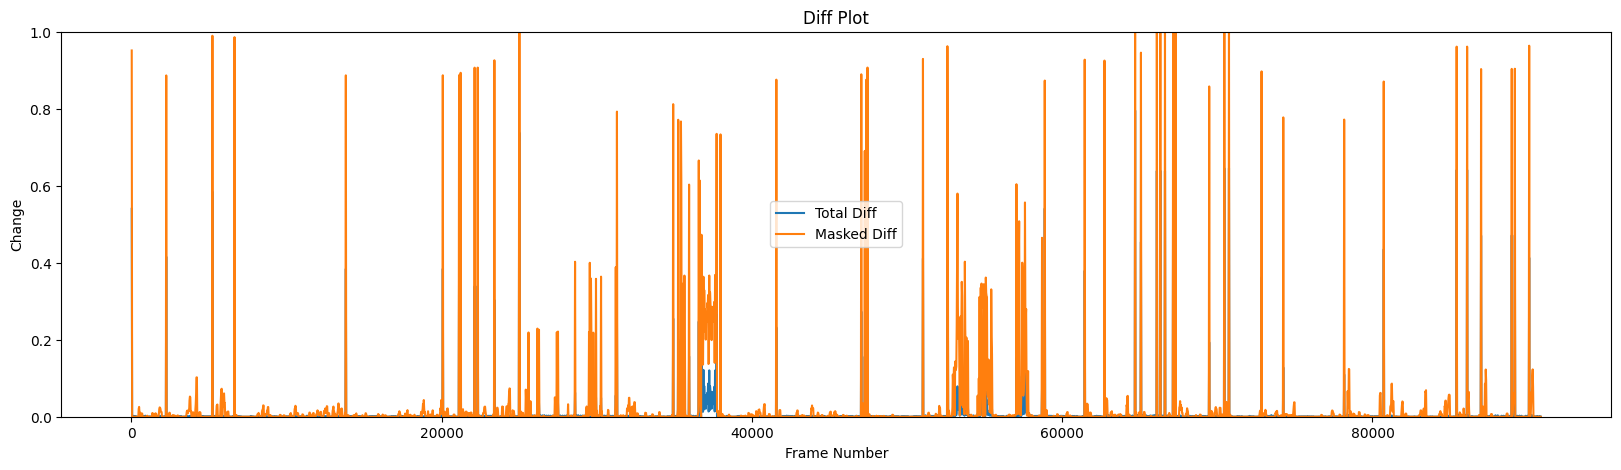

In [9]:
diff, key_frames = v2s.extract_chunk((VIDEO_PATH, (0, 1e6, 25), True))
v2s.plot_diff(diff)

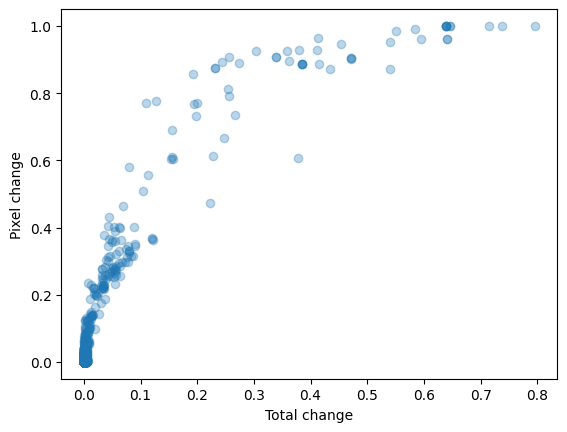

In [13]:
diff_np = np.array(diff)
plt.scatter(diff_np[:, 1], diff_np[:, 2], alpha=0.3)
plt.xlabel('Total change')
plt.ylabel('Pixel change')
plt.show()